# Python + Pandas is love

![Logo Pandas](pics/pandas_logo.png)

~~Excel~~ [Pandas](https://pandas.pydata.org/) !

<img src="pics/logo_sunny.svg" width="33%" style="display:block; margin-left:auto; margin-right:auto">

[Version page web](https://nbviewer.jupyter.org/github/flo-dhalluin/python-pandas-talk/blob/master/pandas-talk-run.ipynb)

## Le cas d'usage simple : 

- Valider une intuition
- un rapport simple à partir de données brutes
- un petit script oneshot vite fait 


In [1]:
%matplotlib inline

## La base


Sortons les outils : 

In [2]:
import pandas as pd 
import numpy as np

### La base : Serie

Une série, est une séquence de valeurs, de type homogène (toutes du même type : String, entiers, flotants, dates ... ), __ avec un index __

In [3]:
pd.Series([6,5,4,3,2,1], index=10 * np.arange(6)) # index par default : 0, 1 .. 


0     6
10    5
20    4
30    3
40    2
50    1
dtype: int64

### La base : Dataframe

Un Dataframe, c'est un tableau : 
- un ensemble de Series, nommées ( les colonnes)
- qui partagent un index


In [4]:
data = pd.DataFrame({"time": pd.date_range("2018-01-01", periods=120, freq="2H"),
                     "value": np.random.random(120),                            
                     "category": pd.Categorical(list("abcdef" * 20))}) 
data.head()

,category,time,value
0,a,2018-01-01 00:00:00,0.255940
1,b,2018-01-01 02:00:00,0.072701
2,c,2018-01-01 04:00:00,0.705675
3,d,2018-01-01 06:00:00,0.620034
4,e,2018-01-01 08:00:00,0.711455


### La base : Import/Export

L'idée étant évidemment d'importer nos données ici, et pas de les générer. Pandas supporte à peu près tout les fichiers formats de données courants :
- csv 
- excel 
- hdf5 
- json/msgpack/parquet

_mais aussi_  on peut créer un dataframe directement depuis une requête SQL, ou même Big Query.

Nous allons ici utiliser la lingua franca de la data ... LE CSV

In [5]:
events = pd.read_csv("events.csv", 
                     delimiter=";", 
                     index_col=0,
                     parse_dates=True) # auto magie. 
events.sort_index(inplace=True)
events.head(5)

,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-01 00:49:35,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,RIB,True
2017-01-01 00:52:45,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,CNI,True
2017-01-01 00:55:10,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,PAYSLIP,False
2017-01-01 00:55:47,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,PAYSLIP,True
2017-01-01 00:56:05,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,SIGNATURE,NaN,True


Une petite vérif rapido :

In [6]:
events.describe()

,client_uuid,type,doc_type,status
count,23518,23518,18755,23518
unique,5000,2,4,2
top,e310f451-8c44-4743-9bbc-6ea301205fef,DOC,RIB,True
freq,10,18755,7748,16036


4 valeurs possibles pour doc_type et beaucoup de "non-valeurs" pour doc_type donc : 
on nettoye tout ça. 

In [7]:
events.type = events.type.astype("category")
events.doc_type = events.doc_type.fillna("UNKNOWN").astype("category")


### Le problème
Nous voudrions compiler un peu des stats sur le nombre de soumission, par type de document ... ( combien de soumission par dossier / type de document, le timing .. )


### Requêtes simples : par index

<font color="red"> Bon gros warning :   l'opérateur `[]` est contre-intuitif. </font>


Pour retrouver des lignes par index :  c'est `.iloc` (index numérique ) ou `.loc` (index déclaré )

In [8]:
events.iloc[241]  # par index de la ligne

client_uuid    257997a7-bdc8-4435-9807-3e0bfe898acd
type                                            DOC
doc_type                                    PAYSLIP
status                                         True
Name: 2017-01-01 15:06:07, dtype: object

avec la syntaxe slice de python : (rappel : l'index est le timestamp)

In [9]:
# Tous les évenements du 10 janvier au 11 janvier (exclus)
events.loc['2017-01-10':'2017-01-11'].head(4)

,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-10 00:05:39,5fdecb46-0439-4c83-bcbc-d4ea421dcef2,SIGNATURE,UNKNOWN,True
2017-01-10 00:15:40,ca1b85f1-3e79-45cc-9c40-0b44945de1a1,DOC,RIB,True
2017-01-10 00:16:43,ca1b85f1-3e79-45cc-9c40-0b44945de1a1,DOC,TAX_NOTICE,True
2017-01-10 00:20:43,ca1b85f1-3e79-45cc-9c40-0b44945de1a1,SIGNATURE,UNKNOWN,True


En fait Il y a 2 cas d'usages pour `[]` 

selection d'une ou plusieurs colonnes :



In [10]:
events[["doc_type", "status"]].head()

,doc_type,status
timestamp,,
2017-01-01 00:49:35,RIB,True
2017-01-01 00:52:45,CNI,True
2017-01-01 00:55:10,PAYSLIP,False
2017-01-01 00:55:47,PAYSLIP,True
2017-01-01 00:56:05,UNKNOWN,True


Ou pour __filtrer__ : avec une série de booléens

In [11]:
import datetime
# Les events concernant des CNI, le 10 janvier
(events[ (events.doc_type == "CNI") 
       & (events.index.date == datetime.date(2017, 1, 10)) ]
       .head(5))


,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-10 01:36:33,b445a26e-5987-4ad7-84dd-f99413c51526,DOC,CNI,True
2017-01-10 05:26:02,d961ac22-d956-4ebd-a8d8-2ad44faa073d,DOC,CNI,False
2017-01-10 05:30:44,d961ac22-d956-4ebd-a8d8-2ad44faa073d,DOC,CNI,True
2017-01-10 07:48:47,c2e208fb-d3cb-42a0-85d8-8a5770dc1c0c,DOC,CNI,True
2017-01-10 08:58:35,86a07ade-da8d-43d8-a259-c9d4d08f3513,DOC,CNI,False


Ou encore `query()` qui est parfois plus lisible, et plus puissante :

In [12]:
# un peu plus lisible : les CNI avant le 10 janvier,
# en erreur ( status : False)
(events.query('doc_type=="CNI" & index < "20170110" & ~status')
      .head())

,client_uuid,type,doc_type,status
timestamp,,,,
2017-01-01 06:17:41,0417341e-9ea3-4cb0-9e2b-bb8765ab65f5,DOC,CNI,False
2017-01-01 11:41:00,57644be9-6533-40ea-ad2f-09be119b87f1,DOC,CNI,False
2017-01-01 11:41:31,57644be9-6533-40ea-ad2f-09be119b87f1,DOC,CNI,False
2017-01-01 12:07:35,feaa9113-5f8f-49a9-89c2-b020b5f070eb,DOC,CNI,False
2017-01-01 12:08:06,feaa9113-5f8f-49a9-89c2-b020b5f070eb,DOC,CNI,False


## GroupBy

> Tableau croisé dynamique, c'est mieux si on en reste là.

Passons dans le vif du sujet, et moulinons un peu nos datas...

![groupby](./pics/groupby.svg.png)

In [13]:
events["timestamp"] = events.index # je crée une colonne ( l'index est perdu dans un groupby )

In [14]:
events["submission_idx"] = (events.groupby(("client_uuid", "doc_type"))
                                  ["timestamp"]
                                  .transform(np.argsort))
events.head()

,client_uuid,type,doc_type,status,timestamp,submission_idx
timestamp,,,,,,
2017-01-01 00:49:35,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,RIB,True,2017-01-01 00:49:35,0
2017-01-01 00:52:45,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,CNI,True,2017-01-01 00:52:45,0
2017-01-01 00:55:10,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,PAYSLIP,False,2017-01-01 00:55:10,0
2017-01-01 00:55:47,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,PAYSLIP,True,2017-01-01 00:55:47,1
2017-01-01 00:56:05,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,SIGNATURE,UNKNOWN,True,2017-01-01 00:56:05,0


Cette fois ci, je veux calculer le temps passé par utilisateur _depuis le premier évenement lié à cet utilisateur_

In [15]:
events['time_since_first'] = (events.groupby('client_uuid')
                              ["timestamp"]
                              .transform(lambda ts: ts-ts[0])) # C'est là !

events.sort_values(by=["client_uuid", "timestamp"]).head()

,client_uuid,type,doc_type,status,timestamp,submission_idx,time_since_first
timestamp,,,,,,,
2017-01-06 20:03:21,000f4284-fda0-4a9a-88d7-f0b8c1c29d5a,DOC,CNI,True,2017-01-06 20:03:21,0,00:00:00
2017-01-06 20:05:52,000f4284-fda0-4a9a-88d7-f0b8c1c29d5a,DOC,PAYSLIP,False,2017-01-06 20:05:52,0,00:02:31
2017-01-06 20:06:52,000f4284-fda0-4a9a-88d7-f0b8c1c29d5a,DOC,PAYSLIP,True,2017-01-06 20:06:52,1,00:03:31
2017-01-06 20:09:42,000f4284-fda0-4a9a-88d7-f0b8c1c29d5a,DOC,RIB,True,2017-01-06 20:09:42,0,00:06:21
2017-01-06 20:19:04,000f4284-fda0-4a9a-88d7-f0b8c1c29d5a,SIGNATURE,UNKNOWN,True,2017-01-06 20:19:04,0,00:15:43


statistiques du nombre de soumissions par type de doc (et après on arrête... )

In [16]:
(events.groupby(("doc_type", "submission_idx"))
                .time_since_first
                .aggregate([("counts", "count"),
                            ("mean_time", lambda g: g.mean())]))

counts       mean_time
doc_type   submission_idx                        
CNI        0                 2058 00:01:51.977648
           1                  815 00:04:26.699386
           2                  305 00:06:50.236065
PAYSLIP    0                 2058 00:05:41.584062
           1                  820 00:08:06.714634
           2                  328 00:10:29.826219
RIB        0                 5000 00:01:37.081600
           1                 1963 00:04:07.510443
           2                  785 00:06:46.805095
TAX_NOTICE 0                 2942 00:03:52.992182
           1                 1193 00:06:16.720871
           2                  488 00:08:37.743852
UNKNOWN    0                 4763 00:11:50.593323


![groupby](./pics/pivot.svg.png)


In [17]:
submission_counts = pd.pivot_table(events, 
                   index="client_uuid",
                   columns="doc_type",
                   values="timestamp",
                   aggfunc="count")

submission_counts.head()

doc_type,CNI,PAYSLIP,RIB,TAX_NOTICE,UNKNOWN
client_uuid,,,,,
000f4284-fda0-4a9a-88d7-f0b8c1c29d5a,1.0,2.0,1.0,NaN,1.0
00237793-d05c-4a8f-a1a9-6e4ed85871eb,NaN,NaN,3.0,1.0,1.0
002c0ef4-53e0-4cd0-92ee-bad1742b6569,NaN,NaN,2.0,1.0,1.0
00303bf8-9e3e-4a98-96af-df83cba3cd23,2.0,1.0,1.0,NaN,1.0
003ca32e-a762-48c1-a892-fe7b02bf90b3,NaN,NaN,2.0,2.0,1.0


In [18]:
submission_counts.describe()

doc_type,CNI,PAYSLIP,RIB,TAX_NOTICE,UNKNOWN
count,2058.000000,2058.000000,5000.000000,2942.000000,4763.0
mean,1.544218,1.557823,1.549600,1.571380,1.0
std,0.738047,0.752122,0.749435,0.759505,0.0
min,1.000000,1.000000,1.000000,1.000000,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.0
50%,1.000000,1.000000,1.000000,1.000000,1.0
75%,2.000000,2.000000,2.000000,2.000000,1.0
max,3.000000,3.000000,3.000000,3.000000,1.0


### Des graphiques ! 

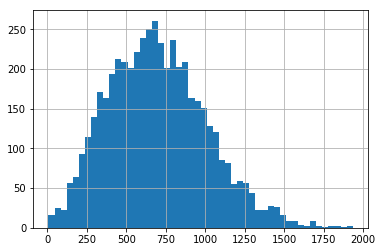

In [19]:
# temps passé par dossier

(events.groupby('client_uuid')
     .time_since_first # juste le temps depuis la première action
     .max() # l'évenement le plus long... 
     .map(lambda x: x.total_seconds())
     .hist(bins=50)) # KABOOM !

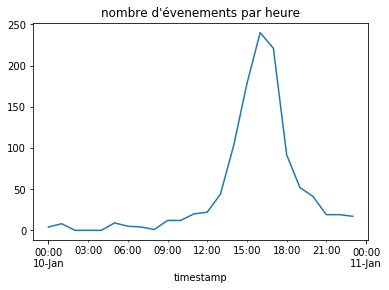

In [20]:
(events.loc["20170110"] 
        .resample('H') # H - aggregation par heure
        .doc_type
        .count().plot(title="nombre d'évenements par heure"))

### Et maintenant ? 

Vous avez la base, vous pouvez plonger plus loin : 
- `.merge` et `.join` : si j'ai 2 tables, des jointures comme à la maison ! 
- les timeseries, et tout ce qu'on peut faire avec ( resampling, rolling windows, conversions .. )

Et une fois que vous avez bien tout nettoyé, évidement, on peut jouer avec scikit-learn pour faire du Machine learning, ou [bokeh](https://bokeh.pydata.org/) pour des zouli graphiques, direct depuis pandas.

# Merci ! 

- Cette présentation est un notebook dispo sur github :
    [https://github.com/flo-dhalluin/python-pandas-talk](https://github.com/flo-dhalluin/python-pandas-talk)
- fait avec [jupyter / notebook](https://jupyter.org/)


 <img src="pics/twitter.png" width="50px" style="display:inline"/>  [@flal](https://twitter.com/flal)
 
 [Netheos recrute !](https://www.netheos.com), venez m'en parler ! 

### Join (ou pluôt ... merge )

Des jointures, comme à la maison ! 

In [21]:
clients = pd.read_csv("client_files.csv", delimiter=";", index_col=0)
clients.head()

,date_created,product,first_name,last_name,dob
uuid,,,,,
b31c08b3-f68d-47f2-9e32-bc63a4f2569c,2017-01-01T00:44:49,LEASING_VOITURE,Émile,Bernier,1998-05-24
67d04076-a809-4541-a40b-32a681b344c9,2017-01-01T04:52:52,ASSURANCE_A,Franck,Lopes,1998-06-14
0417341e-9ea3-4cb0-9e2b-bb8765ab65f5,2017-01-01T06:15:05,LEASING_VOITURE,Alphonse,Rodrigues,1998-06-04
60518499-cf6b-463f-844e-4808ba82fecb,2017-01-01T07:45:44,CARTE_CREDIT,Georges,Auger,1998-05-23
c4e4f2f1-eb85-42df-acec-0811bbab42ca,2017-01-01T08:43:10,ASSURANCE_A,Roland,Martineau,1998-06-15


In [22]:
merged = pd.merge(events, clients, 
                 left_on="client_uuid", 
                 right_index=True, 
                 how="left") # ou bien inner, outer .
# equivalent à 
# events.join(clients, on="client_uuid")
display(merged.head())

,client_uuid,type,doc_type,status,timestamp,submission_idx,time_since_first,date_created,product,first_name,last_name,dob
timestamp,,,,,,,,,,,,
2017-01-01 00:49:35,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,RIB,True,2017-01-01 00:49:35,0,00:00:00,2017-01-01T00:44:49,LEASING_VOITURE,Émile,Bernier,1998-05-24
2017-01-01 00:52:45,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,CNI,True,2017-01-01 00:52:45,0,00:03:10,2017-01-01T00:44:49,LEASING_VOITURE,Émile,Bernier,1998-05-24
2017-01-01 00:55:10,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,PAYSLIP,False,2017-01-01 00:55:10,0,00:05:35,2017-01-01T00:44:49,LEASING_VOITURE,Émile,Bernier,1998-05-24
2017-01-01 00:55:47,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,DOC,PAYSLIP,True,2017-01-01 00:55:47,1,00:06:12,2017-01-01T00:44:49,LEASING_VOITURE,Émile,Bernier,1998-05-24
2017-01-01 00:56:05,b31c08b3-f68d-47f2-9e32-bc63a4f2569c,SIGNATURE,UNKNOWN,True,2017-01-01 00:56:05,0,00:06:30,2017-01-01T00:44:49,LEASING_VOITURE,Émile,Bernier,1998-05-24


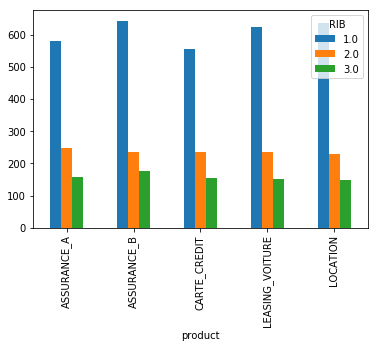

In [23]:
# on va pouvoir faire des stats par produits !
# nombre de resoumissions pour le RIB, par produit

(clients.join(submission_counts)
     .groupby("product")
     .RIB # on regarde les RIB
     .value_counts().unstack()
     .plot.bar())